
General intuition of the code:
- we are simulating a world with agents on a network who choose between EV and gas cars; their decisions depend on (1) what their neighbours do and (2) how much charging infrastructure exists

Plotting functions

# Ratio sweep

One ratio & outcome; reveals tipping points; You vary the initial ratio of EV adopters (or infrastructure level) while keeping other parameters fixed.

You’ve found bistability if:

For some mid-range values, some runs end low and some end high

The results are not a smooth curve but split into two clusters

📌 Two separate plateaus = bistability.
- phase plot: X0 & ration; reveals tipping points and bistability
- spaghetti plot: many simulations; shows how different runs behave over time; reveals multiple stable states (some runs go to 0 some to 1)
- density plot:  similar to spaghetti but smoothed; shows where trajectories cluser

You sweep X₀, I₀, and βᵢ. You uncover:
- critical tipping points
- the size of the bistable region
- how hard (or easy) diffusion is
- how infrastructure feedback matters

From this you conclude: “The system naturally gets stuck unless certain conditions are met.”
This motivates why policy is needed.

Then you rerun the sweeps for different network types. You learn:
- Some networks are more resilient
- Some spread adoption better
- BA networks may need lower X₀
- Random networks may need higher initial adoption

This tells you: “Policy needs to be targeted differently depending on the social structure.”
For example: “Target high-degree hubs first in a BA network.”

Then for the policy design we use the insights from the first 2 parts.

# STEP: Document results and write the report (what to include and where)

For each required part include:
Methods (short):
- Which functions you ran (phase_sweep_df, ratio_sweep_df, collect_intervention_trials)
- Parameter ranges used (list exact ranges)
- Number of trials / batch_size

Results (figures + numbers):
- Phase plot(s) with short caption: what axis means, where tipping boundary is, where bistability shows.
- Ratio sweep plots for representative X₀ values — mark where X* jumps.
- Spaghetti/density/fanchart for baseline vs policy (show mean final X*, quantiles, histograms).
- A short table with numeric summaries: final mean X* (baseline) vs final mean X* (policy), and percent of runs that ended > 0.8.

Policy Interpretation:
- Why the policy works in terms of the model mechanics (moves you across tipping boundary; boosts infrastructure feedback; seeds hubs).
- Practical limitations and assumptions (modelled agents are stylized; network types simplified).

Limitations: model simplifications, choice of parameter ranges, finite trial counts, sensitivity to tau, etc.

# FINAL / reproducibility checklist (what to commit to Git)

Code/ev_core.py (unchanged)

Code/ev_experiments.py (unchanged)

Code/ev_plotting.py (unchanged)

Code/my_assignment.ipynb (your notebook with the cells above + comments)

README.md — short “run me” instructions: pip install -r requirements.txt, then jupyter notebook and run Code/my_assignment.ipynb or python Code/ev_experiments.py for demo.

plots/ — include final .png images referenced in report

report/ — the PDF report and presentation PDF

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import os
import seaborn as sns



from ev_experiments import (
    run_timeseries_trial,
    ratio_sweep_df,
    phase_sweep_df,
    traces_to_long_df,
    collect_intervention_trials
)

from ev_plotting import (
    plot_ratio_sweep,
    plot_phase_plot,
    plot_spaghetti,
    plot_density,
    plot_fanchart
)


# Baseline scenario dictionary
Goal: run sweeps for X₀, I₀, and βᵢ; detect tipping points & bistability.

Use phase_sweep_df (2D X₀ × ratio heatmap) and ratio_sweep_df (1D ratio → X*). Use spaghetti/density selectively to show bistability at specific parameter settings.

In [2]:
scenario_base = dict( # creates a dictionary of parameters we can pass to sweep fuctions
    I0=0.05, # infrastructure level 
    beta_I=2.0, # how strongly infrastructure increases the coordination payoff a_i = a0 + beta_I * I
    b=1.0, # baselnie payoff for D (ICE); used to compute a_i/b
    g_I=0.05, # infrastructure adjustment rate (how quick infrastructure responds to adoption)
    network_type="BA",    # You can change this later for Part 2
    n_nodes=120,
    p_WA=0.1,
    k=4,
    p_ER=0.05, # edge probability (ER)
    m=2, # number of edges to attach for new nodes (BA)
)


# Parameter sweep X0 x ratio
This is the core baseline plot. Suggested exploratory resolution: X₀ 21 points, ratio 41 points.

How to interpret (for report):

Look for sharp color changes (blue→yellow) across X₀ at fixed ratio → tipping point.

Mixed-color vertical bands or “patchy” areas indicate bistability (same params give different outcomes across replicates).

The white dashed line X = 1 / ratio is theoretical threshold; compare model results to it.

In [3]:
X0_values = np.linspace(0, 1, 21) # Creates 21 evenly spaced initial adoption fractions from 0.0 to 1.0
ratio_values = np.linspace(0.8, 3.5, 41) # Creates 41 values for the payoff ratio a_I / b to sweep across plausible values.

phase_df = phase_sweep_df(
    X0_values = X0_values,
    ratio_values = ratio_values,
    scenario_kwargs = scenario_base,
    batch_size = 3,        # for computational efficiency
    init_noise_I = 0.04,
    T = 100, # for computational efficiency
    strategy_choice_func = "logit",
    tau = 1.0,
    max_workers = 1,
    backend = "thread"
)

filename2=f"plots/parameter_sweep_X0.png"
fig2_path = plot_phase_plot(phase_df, out_path= filename2, fig_title="Parameter sweep X0 x ratio" )
print("Saved phase plot to:", fig2_path)


Saved phase plot to: plots/parameter_sweep_X0.png


# Parameter sweep I0 x ratio

In [4]:
I0_values = np.linspace(0, 1, 21) 
ratio_values = np.linspace(0.8, 3.5, 41) 
phase_df = phase_sweep_df(
    X0_values = I0_values,
    ratio_values = ratio_values,
    scenario_kwargs = scenario_base,
    batch_size = 3,        # for computational efficiency
    init_noise_I = 0.04,
    T = 100, # for computational efficiency
    strategy_choice_func = "logit",
    tau = 1.0,
    max_workers = 1,
    backend = "thread"
)

filename=f"plots/parameter_sweep_I0.png"
fig_path = plot_phase_plot(phase_df, out_path=filename, fig_title = "Parameter sweep I0 x ratio")
print("Saved phase plot to:", fig_path)


Saved phase plot to: plots/parameter_sweep_I0.png


# Parameter sweep beta_I x ratio - The assignment mentions sensitvty curves for beta

In [7]:
beta_I__values = np.linspace(0, 1, 21) 
ratio_values = np.linspace(0.8, 3.5, 41) 
phase_df = phase_sweep_df(
    X0_values = beta_I__values,
    ratio_values = ratio_values,
    scenario_kwargs = scenario_base,
    batch_size = 3,        # for computational efficiency
    init_noise_I = 0.04,
    T = 100, # for computational efficiency
    strategy_choice_func = "logit",
    tau = 1.0,
    max_workers = 1,
    backend = "thread"
)

filename3=f"plots/parameter_sweep_betaI.png"
fig3_path = plot_phase_plot(phase_df, out_path=filename3, fig_title="Parameter sweep beta_I x ratio")
print("Saved phase plot to:", fig3_path)


Saved phase plot to: plots/parameter_sweep_betaI.png


# Ratio sweep (fixed X0)
Pick typical X₀ values (e.g., 0.1, 0.2, 0.4). This shows 1D tipping curves. In the code below we run the sweeps for 3 X0 values to detect how sensitive tipping points are to initial EV adoption.

Interpretation: sudden vertical-like jumps on these plots indicate tipping points for that X₀.

Example wording for the report: "We performed ratio sweeps at multiple fixed initial adoption levels (X₀ = 0.10, 0.20, 0.40).
Each individual sweep keeps X₀ constant and varies the payoff ratio.
Comparing these sweeps reveals how the tipping point shifts with initial adoption."

In [ ]:
# this will give us 4 plots, all with different fixed x0 (0.1, 0.2,0.4,0.6). we can use these plots to show tipping behavior at around certain values. 
# i chose hese numbers based on the phase plot - the lower ones show close to none tipping behavior. the more you increase the more tipping occurs
for X0 in [0.1,0.20,0.40,0.60]:
    print("Running ratio sweep for X0 =", X0)
    sweep_df = ratio_sweep_df(
        X0_frac = X0,
        ratio_values = np.linspace(0.8, 3.5, 41),
        scenario_kwargs = scenario_base,
        batch_size = 5,
        T = 150,
        strategy_choice_func = "logit",
        tau = 1.0
    )
    filename4 = f"plots/ratio_sweep_X0_{X0}.png"
    fig4_path = plot_ratio_sweep(sweep_df, out_path=filename4, fig_title=f"Ratio sweep X0 = {X0}")
    print("Saved ratio sweep:", fig4_path)


Running ratio sweep for X0 = 0.1
Saved ratio sweep: plots/ratio_sweep_X0_0.1.png
Running ratio sweep for X0 = 0.2
Saved ratio sweep: plots/ratio_sweep_X0_0.2.png
Running ratio sweep for X0 = 0.4
Saved ratio sweep: plots/ratio_sweep_X0_0.4.png
Running ratio sweep for X0 = 0.6


KeyboardInterrupt: 

# Ratio sweep (fixed I0)

In [6]:
# this will give us 4 plots, all with different fixed i0 (0.1, 0.2,0.4,0.6). we can use these plots to show tipping behavior at around certain values. 
# i chose hese numbers based on the phase plot - the lower ones show close to none tipping behavior. the more you increase the more tipping occurs
for I0 in [0.1,0.2,0.4,0.6]:
    print("Running for I0", I0)
    sweep_df = ratio_sweep_df(
        X0_frac=I0,
        ratio_values = np.linspace(0.8,3.5,41),
        scenario_kwargs=scenario_base,
        batch_size=3,
        T=100,
        strategy_choice_func="logit",
        tau=1
    )
    filename5=f"plots/ratio_sweep_I0_{I0}.png"
    fig5_path = plot_ratio_sweep(sweep_df,out_path=filename5, fig_title=f"Ratio sweep I0 = {I0}")
    print("Saved ratio sweep:", fig5_path)

Running for I0 0.1


KeyboardInterrupt: 

# Ratio sweep (fixed beta)

In [ ]:
# this will give us 4 plots, all with different fixed beta (0.1, 0.2,0.4,0.6). we can use these plots to show tipping behavior at around certain values. 
# i chose hese numbers based on the phase plot - the lower ones show close to none tipping behavior. the more you increase the more tipping occurs
for beta_i in [0.1,0.2,0.4,0.6]:
    print("Running for beta_i", beta_i)
    sweep_df = ratio_sweep_df(
        X0_frac=beta_i,
        ratio_values = np.linspace(0.8,3.5,41),
        scenario_kwargs=scenario_base,
        batch_size=3,
        T=100,
        strategy_choice_func="logit",
        tau=1
    )
    filename6=f"plots/ratio_sweep_beta_{beta_i}.png"
    fig6_path = plot_ratio_sweep(sweep_df, out_path=filename6, fig_title=f"Ratio sweep beta_I = {beta_i}")
    print("Saved phase plot to:", fig6_path)

Running for beta_i 0.1
Saved phase plot to: plots/ratio_sweep_beta_0.1.png
Running for beta_i 0.2
Saved phase plot to: plots/ratio_sweep_beta_0.2.png
Running for beta_i 0.4
Saved phase plot to: plots/ratio_sweep_beta_0.4.png
Running for beta_i 0.6
Saved phase plot to: plots/ratio_sweep_beta_0.6.png


# Show bistability and path dependence with spaghetti/denisty 
Pick a parameter setting inside the mixed zone from the phase plot (e.g., ratio ≈ 1.5, X₀ ≈ 0.3). Run collect_intervention_trials with no policy to collect many trajectories, then plot spaghetti/density.
Interpretation:

If many traces split to 0 or 1 from the same settings → bistability / path dependence. Use a histogram of final X(T) to show bimodality.

In [ ]:
scenario_bist = {**scenario_base, "ratio": 1.5, "X0_frac": 0.6}  # chose x0 and ratio where tiping occurs

baseline_X, baseline_I, subs_X, subs_I, base_df, subs_df = collect_intervention_trials(
    n_trials=80,
    T=100,
    scenario_kwargs=scenario_bist,
    subsidy_params=None,
    max_workers=1,
    seed_base=42
)

traces_df = traces_to_long_df(baseline_X, baseline_X)

# Spaghetti plot
fig7a_path = plot_spaghetti(
    traces_df,
    out_path="plots/spaghetti_bistability.png",
    fig_title="Spaghetti plot - bistability"
)

# Density plot
fig7b_path = plot_density(
    traces_df,
    time_bins=200,
    out_path="plots/density_bistability.png",
    fig_title="Density plot - bistability"
)

print("Spaghetti plot saved to:", fig7a_path)
print("Density plot saved to:", fig7b_path)


Spaghetti plot saved to: plots/spaghetti_bistability.png
Density plot saved to: plots/density_bistability.png


# Network structure comparison

Goal: run the same baseline sweeps for different network topologies and compare.

Supported networks in your code: "random" (Erdős–Rényi) and "BA" (Barabási–Albert). For a want a third (e.g., Watts–Strogatz), you can add it by implementing a small function that constructs a WS graph in ev_core.py and exposing it. Do the same phase_sweep_df and ratio_sweep_df for each network type.

How to compare:
- Place the images side-by-side in your report or presentation.
- Note where the tipping boundary moves: networks with hubs (BA) often require lower X₀ to tip if hubs are seeded.

If you want to demonstrate seeding hubs vs random seeding: use set_initial_adopters(..., method="degree", high=True) when running run_timeseries_trial in a small loop — I can give exact code for targeted seeding if you want.


In [8]:
networks = ["random", "BA","WA"]
for net in networks:
    print("Network:", net)
    scen = {**scenario_base, "network_type": net}
    phase_df_net = phase_sweep_df(
        X0_values = np.linspace(0.0, 1.0, 21),
        ratio_values = np.linspace(0.8, 3.5, 41),
        scenario_kwargs = scen,
        batch_size = 3,
        T = 100,
        strategy_choice_func = "logit",
        tau = 1.0,
        max_workers = 1,
        backend = "thread"
    )
    filename8=f"plots/phase_sweep_{net}.png"
    fig8_path = plot_phase_plot(phase_df_net, out_path=filename8, fig_title=f"Phase sweep: {net} network")
    shutil.move(fig8_path, filename8)
    print("Saved phase plot for", net, "to", filename8)



Network: random
Saved phase plot for random to plots/phase_sweep_random.png
Network: BA
Saved phase plot for BA to plots/phase_sweep_BA.png
Network: WA
Saved phase plot for WA to plots/phase_sweep_WA.png


# Fanchart - Speed of adoption, probability of reaching high adoption equilibrim, sensitivity to tipping


### 1️⃣ **Speed of adoption**

✅ **Yes, partially.**

* The **top row of fan charts** shows adoption (`X(t)`) over time.
* **Steepness of the mean line** or the **time it takes most trials to reach high X(t)** gives you a measure of adoption speed.
* **Narrow vs wide bands** indicate how consistent that speed is across trials.

> So you can **compare adoption speed across networks or scenarios**, but it’s not a single numeric value — it’s visual.

---

### 2️⃣ **Probability of reaching the high-adoption equilibrium**

✅ **Yes, you can estimate.**

* The **bottom row histogram of final X(T)** shows how many trials end near full adoption.
* For example:

  * If all bars cluster near 1 → probability ≈ 1
  * If some trials are low and some high → bistable / partial probability
* You can **quantify it** by computing the fraction of trials with `X(T) > threshold` (e.g., 0.9).


### **Network-specific sensitivity to tipping**

✅ **Yes, visually.**

* Run the fan chart for **different networks** at the **same X0_frac and ratio**.
* Compare:

  * How quickly adoption spreads (`speed`)
  * How variable the final adoption is (width of histogram)
* Networks with more variability or delayed adoption are **more sensitive to tipping parameters**.


Run many trials at a parameter setting where adoption does succeed, then plot spaghetti or density. Look for whether one netowrk's density moves up earlier in time or if it reaches high X faster.

Expected: Scale-free networks exhibit faster adoption, as hubs rapidly influence large portions of the network once coordination begins.

In [ ]:

os.makedirs("plots", exist_ok=True)
X0_frac = 0.6
ratio = 1.5

for net in ["random", "BA", "WA"]:
    scenario_net = {**scenario_base, "network_type": net, "X0_frac": X0_frac, "ratio": ratio}

    baseline_X, baseline_I, subs_X, subs_I, base_df, subs_df = collect_intervention_trials(
        n_trials=80,
        T=100,
        scenario_kwargs=scenario_net,
        subsidy_params=None,
        max_workers=4,
        seed_base=42
    )

    traces_df = traces_to_long_df(baseline_X, subs_X)

    filename12 = f"plots/fanchart_{net}.png"
    fig12_path = plot_fanchart(
        traces_df,
        out_path=filename12,
        fig_title=f"Fan chart - {net} network"
    )

    print("Saved fan chart to:", fig12_path)


Saved fan chart to: plots/fanchart_random.png
Saved fan chart to: plots/fanchart_BA.png
Saved fan chart to: plots/fanchart_WA.png


# speed of adoption (another option - not sure exactly what we need here)

        time_to_target                                             
                 count      mean       std  min  25%  50%  75%  max
network                                                            
BA                49.0  0.061224  0.242226  0.0  0.0  0.0  0.0  1.0
WA                50.0  0.560000  0.501427  0.0  0.0  1.0  1.0  1.0
random            46.0  0.586957  0.497821  0.0  0.0  1.0  1.0  1.0


C:\Users\ecate\AppData\Local\Temp\ipykernel_14032\2026667893.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


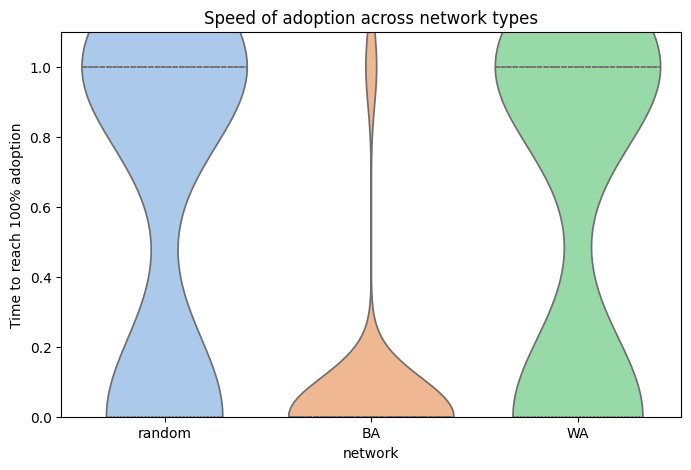

In [13]:


networks = ["random", "BA", "WA"]
target_adoption = 1  # threshold for "adopted"
speed_data = []

for net in networks:
    scenario_net = {
        **scenario_base,
        "network_type": net,
        "X0_frac": 0.8,
        "ratio": 3.0  # can adjust if you want near-tipping behavior
    }

    # Run your simulation
    baseline_X, _, _, _, _, _ = collect_intervention_trials(
        n_trials=50,
        T=100,
        scenario_kwargs=scenario_net,
        subsidy_params=None
    )

    # Compute time to reach target adoption for each trial
    for trial in baseline_X:
        times = np.argmax(trial >= target_adoption)
        if trial[-1] < target_adoption:
            times = np.nan  # trial never reached target
        speed_data.append({"network": net, "time_to_target": times})

# Convert to DataFrame for easy plotting
speed_df = pd.DataFrame(speed_data)

# Summary statistics
print(speed_df.groupby("network").describe())

# Filter out trials that never reached the target
plot_df = speed_df.dropna(subset=["time_to_target"])

# Violin plot
plt.figure(figsize=(8,5))
sns.violinplot(
    x="network",
    y="time_to_target",
    data=plot_df,
    inner="quartile",
    palette="pastel"
)
plt.ylabel(f"Time to reach {target_adoption*100:.0f}% adoption")
plt.title("Speed of adoption across network types")
plt.ylim(0, plot_df["time_to_target"].max() + 0.1)  # nice padding above max
plt.show()




# Probability of reaching high-adoption equilibrium
What it means: Out of many runs, how often does the system end up with high EV adoption? This is not about speed — it’s about success rate.

Measure it by running many trials and counting how many end with X*>0.8

In [ ]:
for net in ["random", "BA","WA"]:
    scenario_net = {
        **scenario_base,
        "network_type": net,
        "X0_frac": 0.6,  # chose x0 and ratio where tiping occurs
        "ratio": 1.5   
    }

    baseline_X, _, _, _, _, _ = collect_intervention_trials(
        n_trials=100,
        T=100,
        scenario_kwargs=scenario_net,
        subsidy_params=None
    )

    final_X = np.array([x[-1] for x in baseline_X])
    prob_high = np.mean(final_X > 0.8)

    print(net, "probability of high adoption:", prob_high)

random probability of high adoption: 0.84
BA probability of high adoption: 0.57
WA probability of high adoption: 1.0


# Cluster formation
This is about local coordination, looking at how EV adopters form local groups before spreading globally. You can detect it by infering it from delayed takeoff, sudden jumps, early flat trajectories followed by rapid growth

In [ ]:
for net in ["random", "BA","WA"]:
    scenario_net = {
        **scenario_base,
        "network_type": net,
        "X0_frac": 0.6,  # chose x0 and ratio where tiping occurs
        "ratio": 1.5
    }

    baseline_X, _, _, _, _, _ = collect_intervention_trials(
        n_trials=50,
        T=100,
        scenario_kwargs=scenario_net,
        subsidy_params=None
    )

    traces_df = traces_to_long_df(baseline_X, baseline_X)

    fig10_path = plot_density(traces_df, fig_title=f"Cluster formation: {net} network")
    filename10=f"plots/cluster_formation_{net}.png"
    shutil.move(fig10_path, filename10)
    print("Saved phase plot to:", filename10)


Saved phase plot to: plots/cluster_formation_random.png
Saved phase plot to: plots/cluster_formation_BA.png
Saved phase plot to: plots/cluster_formation_WA.png


# Policy intervention example - this isn't ready

In [ ]:
subsidy = dict(start=20, end=80, delta_a0=0.4)

baseline_X, baseline_I, subsidy_X, subsidy_I, base_df, subs_df = \
    collect_intervention_trials(
        n_trials=50,
        T=100,
        scenario_kwargs=scenario_base,
        subsidy_params=subsidy,
    )

traces_df = traces_to_long_df(baseline_X, subsidy_X)
plot_spaghetti(traces_df)
plot_density(traces_df)


'c:\\Users\\ecate\\Desktop\\Assignment 3\\Assignment-3-MBDM\\plots\\ev_density.png'